In [1]:
import pandas as pd
import numpy as np

from news_vec.corpus import Corpus

from tqdm import tqdm
from boltons.iterutils import windowed
from collections import Counter
from itertools import combinations

from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
corpus = Corpus('../data/clf-links.json/', '../data/clf-headlines.json/')

2018-12-26 02:11:37,618 | INFO : Reading links.
1225511it [00:03, 351585.48it/s]
2018-12-26 02:11:42,995 | INFO : Reading headlines.
1127502it [00:21, 53170.27it/s]


In [12]:
min_dts_count = corpus.links.groupby(['domain', 'ts_bucket']).size().min()

In [30]:
def a_vs_b(d1, d2, ts_bucket, n=10):
    
    rows = (corpus.links
         [(corpus.links.domain.isin([d1, d2])) & (corpus.links.ts_bucket==ts_bucket)]
         .groupby(['domain', 'ts_bucket'])
         .apply(lambda x: x.sample(min_dts_count)))
    
    ds = corpus.make_dataset(rows)
    df = ds.to_df()
    
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1,3)
    )
    
    clf = LinearSVC()
    
    X = tv.fit_transform(df.tokens)
    
    return cross_val_score(clf, X, df.domain, cv=n, n_jobs=-1)

In [47]:
domains = corpus.unique_articles.domain.unique()

In [48]:
pairs = list(combinations(domains, 2))

In [ ]:
rows = []
for a, b in tqdm(pairs):
    for i in tqdm(range(10)):
        scores = a_vs_b(a, b, i, 100)
        for s in scores:
            rows.append((a, b, i, s))

 60%|██████    | 6/10 [00:16<00:10,  2.65s/it]

In [112]:
d1 = 'apnews.com'
d2 = 'foxnews.com'
rows = []
for i in tqdm(range(10)):
    scores = a_vs_b(d1, d2, i, 100)
    for s in scores:
        rows.append((d1, d2, i, s))

100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


In [113]:
sdf = pd.DataFrame(rows, columns=('d1', 'd2', 'b', 'acc'))

In [114]:
sdf['pair'] = sdf[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

In [115]:
len(sdf)

1000

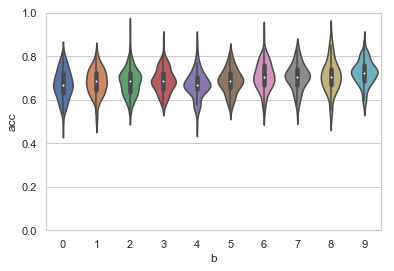

In [119]:
# plt.figure(figsize=(5,30))
plt.ylim(0, 1)
sns.violinplot(x='b', y='acc', data=sdf)

In [95]:
domains

array(['apnews.com', 'bloomberg.com', 'buzzfeed.com', 'dailycaller.com',
       'dailykos.com', 'foxnews.com', 'huffingtonpost.com', 'npr.org',
       'nytimes.com', 'thehill.com', 'washingtonpost.com', 'wsj.com',
       'breitbart.com', 'cnn.com', 'rt.com', 'sputniknews.com'],
      dtype=object)